## evaluate_UNET_Selina Pixelwise -- Cell contours
## New Setup

In this notebook we apply the previously trained model to a set of images and evaluate the quality of the prediction.

This includes the following steps:

* load the original dataset
* prerpocess the dataset (zero center, normalize to range -1 to 1)
* feed the data to the model

* calculate quality measures

In [1]:
!ls /tf/results/models/

Unet_0-0-0.h5		       Unet_0-0-4_20200423-075700.h5
Unet_0-0-0_20200411-124102.h5  Unet_0-0-4_20200423-093523.h5
Unet_0-0-1.h5		       Unet_0-0-5_fl_RAda,_20200507-094138.h5
Unet_0-0-1_20200411-120615.h5  Unet_0-0-5_fl_RAdam_20200426-134706.h5
Unet_0-0-1_20200411-122810.h5  Unet_0-0-5_fl_RAdam_20200512-094113.h5
Unet_0-0-1_20200411-132132.h5  Unet_0-0-5_fl_RAdam_20200522-122844.h5
Unet_0-0-1_20200413-105017.h5  Unet_0-0-5_fl_RAdam_20200525-084831.h5
Unet_0-0-2_20200413-190741.h5  Unet_0-0-5_fl_RAdam_20200602-100339.h5
Unet_0-0-3_20200414-144612.h5  Unet_0-0-5_fl_RAdam_20200602-115253.h5
Unet_0-0-4_20200423-064224.h5  Unet_0-0-5_fl_RAdam_20200603-153056.h5
Unet_0-0-4_20200423-070809.h5  Unet_0-0-5_fl_RAdam_20200610-140630.h5
Unet_0-0-4_20200423-070930.h5  Unet_0-0-5_fl_RAdam_20200610-141144.h5
Unet_0-0-4_20200423-071031.h5  Unet_0-0-5_fl_RAdam_20200615-152004.h5
Unet_0-0-4_20200423-071209.h5  Unet_0-0-5_fl_RAdam_20200615-191423.h5
Unet_0-0-4_20200423-071259.h5  Unet_0-0-5_fl_RAdam_20200

In [2]:
import tensorflow as tf
# TODO: remove after tf2.0 migration
# handle tf API changes 1.x to 2.0
from packaging import version
if version.parse(tf.__version__) < version.parse('2.0'):
    opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=opts))
else:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
## check if tf detected a GPU 
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x for x in local_device_protos if x.device_type == 'GPU']



print("GPU device id: ", tf.test.gpu_device_name())
print("GPU details: \n" , get_available_gpus())

1 Physical GPUs, 1 Logical GPUs
GPU device id:  /device:GPU:0
GPU details: 
 [name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7597241140
locality {
  bus_id: 1
  links {
  }
}
incarnation: 121779730594759205
physical_device_desc: "device: 0, name: Quadro M4000, pci bus id: 0000:65:00.0, compute capability: 5.2"
]


In [4]:
## load the UNet model from UNETmodel.py
# details the the network can be found here: 
from includes.UNETmodel import UNet

# create model takes two arguments, the dimension of the input image (width x height x channels)
# and the number of classes 
# TODO: check if the last activation function is correctly choosen in this implementation!
with tf.device('/cpu:0'):
    #unet = UNet().create_model((540,300,1),1, d=32)
    #unet.load_weights("/tf/results/models/Unet_0-0-1_20200413-105017.h5")
    
    unet = UNet().create_model((720,540,1), 1 , d=8)
    unet.load_weights("/tf/results/models/Unet_0-0-5_fl_RAdam_20200610-141144.h5")

network = 'cell_contours_new_training'

build UNet ...


In [5]:
#Copied Training setup
from datetime import datetime

test_size = 0.2
random_state = 121
epochs = 100
batch_size = 4
learning_rate = 1e-5
loss = 'binary_crossentropy'
metrics = ['accuracy']
stats = dict(
    name="Unet",
    version="0-0-1",
    data_raw="-".join(["gt_0","gt_3","gt_4","gt_5","gt_6","gt_7","gt_8"]),
    data_split="%d-%d"%(test_size*100, random_state),
    model_path="/tf/results/models/",
    model_ext="h5",
    log_path="/tf/results/logs/",
    img_path="/tf/results/singlePredictions/"
)

In [6]:
def preprocess(img):
    return (img - np.mean(img)) / np.std(img).astype(np.float32)

## Prepare pixelwise evaluation

load images and split into two sets: train and test

x: raw image, y: masks, train for the data used for training.

In [7]:
# MAIN PROCESSING LOOP
# load the training images and masks
import os
import imageio
import numpy as np
import clickpoints
from matplotlib.path import Path

# TODO do we export all images or just the ones with ellipsoids? might be good as negative samples?

# Change path to test on test data set
search_path = '../results/cell_contours/train'
file_list = []
for root, dirs, files in os.walk(search_path):
    for file in files:
        if not file.endswith(".cdb"):
            continue
        file_list.append(os.path.abspath(os.path.join(root, file)))

images = []
masks = []

num_cells = 0
images_total = 0
        
for cdb_file in file_list[:4]:
    cdb = clickpoints.DataFile(cdb_file)

    # Get polygons of every image
    q_poly = cdb.getPolygons()
    img_ids = np.unique([pol.image.id for pol in q_poly])
    print("#%d found" % q_poly.count())
    
    print("#%d images" % len(img_ids))
    
    
    
    # How many images in cdb
    q_img = cdb.getImages()
    ids = np.unique([el.sort_index for el in q_img])
    print("#%d images" % len(ids))
    images_total += len(ids)

    nx, ny = 540,720
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T

            
    #Masks for every image if you want to evaluate on not just the positives.
    for id in ids + 1:
     # get image object by id and image data
        img_o = cdb.getImage(id=id)
        img   = img_o.get_data()
        # img = img/im_av
        if len(img.shape) == 3:
            img = img[:,:,0]
            
        # apply pre processing and append to list 
        images.append(np.array(preprocess(img))[:,:,None])
        
        mask = np.zeros((img.shape[0:2]), dtype=np.uint8)
        if id in img_ids:
        # get ellipses in this image 
            q_polys=cdb.getPolygons(image=img_o)
            mask = np.zeros((np.shape(img_o)[0:2]), dtype=np.uint8)
            for pol in q_polys:
                if np.shape(pol)[0] != 0:
                    num_cells += 1
                    polygon = np.array([[pol.points]])
                    path = Path(polygon.squeeze())
                    grid = path.contains_points(points)
                    grid = grid.reshape((ny,nx))
                    mask += grid
        masks.append(mask)

# convert lists to arrays, expand to network expetation of [N x w x h x c]
images = np.array(images)
masks = np.array(masks)[:,:,:,None]

print(images.shape)
print(masks.shape)

no openslide found
path /tf/results/cell_contours/train/gt_8_selina.cdb
Open database with version 22
#241 found
#171 images
#500 images
path /tf/results/cell_contours/train/gt_7_selina.cdb
Open database with version 22
#310 found
#203 images
#500 images
path /tf/results/cell_contours/train/gt_4_selina.cdb
Open database with version 22
#302 found
#182 images
#500 images
path /tf/results/cell_contours/train/gt_5_richard.cdb
Open database with version 22
#411 found
#225 images
#500 images
(2000, 720, 540, 1)
(2000, 720, 540, 1)


## Calculate binary mask as prediction of the network


In [26]:
id = 0
batch_size = images.shape[0] + 5

with tf.device('/cpu:0'):    
    prediction = unet.predict(preprocess(images[id:id+batch_size]))
    #pred_mask_total = pred_total.squeeze()>0.5
#pred_mask_total.shape
prediction.shape

(2000, 720, 540, 1)

In [27]:
print(images.shape, masks.shape, prediction.shape)

(2000, 720, 540, 1) (2000, 720, 540, 1) (2000, 720, 540, 1)


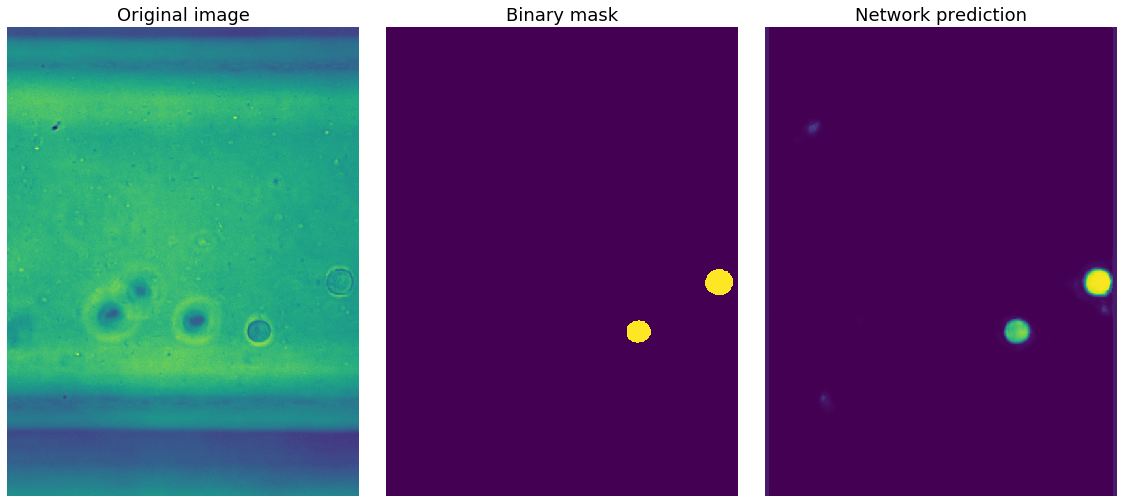

In [46]:
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=18)    
plt.rcParams['axes.linewidth'] = 0.1 #set the value globally


i=10


plt.figure(figsize=[16,7])
# show image
ax = plt.subplot(1,3,1)
ax.set_title('Original image')
plt.imshow(images[i,:,:,0])
plt.axis('off')

# debug show coordinates
ax = plt.subplot(1,3,2)
ax.set_title('Binary mask')
plt.imshow(masks[i,:,:,0])
plt.axis('off')

# show calculated binary mask
ax = plt.subplot(1,3,3)
ax.set_title('Network prediction')

plt.axis('off')
plt.imshow(prediction[i,:,:,0])
plt.tight_layout()
plt.savefig('/tf/results/results_new/'  + 'cell_detection_explanation' + '.png')


## Calculate the binary masks with Canny

In [8]:
#Canny-filter
from skimage import feature
from scipy.ndimage import morphology
struct = morphology.generate_binary_structure(2, 1)  #structural element for binary erosion

binary_mask_canny = []

for id in range(images.shape[0]):    
    im1o = feature.canny(images[id,:,:,0].squeeze(), sigma=2.5, low_threshold=0.6, high_threshold=0.99, use_quantiles=True) #edge detection           
    im2o = morphology.binary_fill_holes(im1o, structure=struct).astype(int) #fill holes
    im3o = morphology.binary_erosion(im2o, structure=struct).astype(int) #erode to remove lines and small dirt
    binary_mask_canny.append(im3o)
binary_mask_canny = np.array(binary_mask_canny)
binary_mask_canny.shape

(2000, 720, 540)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve

print('Canny:')
p_can = precision_score(binary_mask_canny.flatten(),masks.squeeze().flatten())
print('Precision of binary mask: %.4f' %(p_can))
r_can = recall_score(binary_mask_canny.flatten(),masks.squeeze().flatten())
print('Recall of binary mask: %.4f' %(r_can))

Canny:


In [ ]:
cm_can = confusion_matrix(binary_mask_canny.astype(int).flatten(),masks.squeeze().flatten())
print(cm_can)

In [ ]:
print(sum(cm_can))
print(cm_can/sum(cm_can))

In [ ]:
print(masks.shape)
print(prediction.shape)
cm_can[0,1]/(cm_can[0,0] + cm_can[0,1])

## Measure precision and recall

Precision measures the accuracy of the positive predictions. How many of the positive instances are correctly identified.

$$precision = \frac{TP}{TP + FP}$$

Recall measures the sensitivity, i.e. the positive instances that are detected. How many positives are detected.

$$recall = \frac{TP}{TP + FN}$$

F1-Score combines those two criteria: $$ F_1 = \frac{2\cdot precision \cdot recall}{precision + recall}$$

The functions need a 1 dimensional input. Therefore, the arrays have to be flattend. Also, the same length is necessary.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve

fpr, tpr, thresholds = roc_curve(masks.squeeze().flatten(), prediction.squeeze().flatten())

In [1]:
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=18)    
plt.rcParams['axes.linewidth'] = 0.1 #set the value globally

fig, ax = plt.subplots(figsize=[5,4])

plt.plot(fpr,tpr)
plt.plot(cm_can[0,1]/(cm_can[0,0] + cm_can[0,1]),r_can,'o')
plt.plot([0,1],[0,1],'k--')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(['Network','Canny'],loc=4)
fig.tight_layout()

plt.savefig('/tf/results/results_new/ROC/ROC_curve/' + network + '_ROC' + '.png')

from numpy import trapz
area = trapz(tpr, fpr)
print(area)

NameError: name 'fpr' is not defined

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [ ]:
print(thresholds)
print(fpr)
print(tpr)
len(tpr)
fig, ax = plt.subplots(figsize=[5,4])

plt.plot(thresholds,tpr)
plt.plot(thresholds,fpr)
plt.xlabel('Thresholds')
plt.xlim(-0.1,1.1)
plt.legend(['True positive rate', 'False positive rate'],loc=1)
fig.tight_layout()
plt.savefig('/tf/results/results_new/ROC/ROC_curve/' + network + '_tpr_fpr' + '.png')

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

x = find_nearest(thresholds,0.5)
pos05 = np.where(thresholds == x)
print(pos05[0])
print(tpr[pos05])
print(fpr[pos05])

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(masks.squeeze().flatten(), prediction.squeeze().flatten())

In [ ]:
print(len(threshold))
print(len(precision))
print(len(recall))

In [ ]:
#print(threshold)
#print(recall)
#print(precision)
#len(threshold)
fig, ax = plt.subplots(figsize=[5,4])


plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(r_can,p_can,'o')
plt.legend(['Network','Canny'],loc=3)
fig.tight_layout()

plt.savefig('/tf/results/results_new/ROC/ROC_curve/' + network + '_p_vs_r' + '.png')

area = trapz(recall, precision)
print(area)

In [ ]:
print(threshold)
print(fpr)
print(tpr)
len(tpr)
fig, ax = plt.subplots(figsize=[5,4])

plt.plot(threshold,precision[1:])
plt.plot(threshold,recall[1:])
plt.xlabel('Thresholds')
plt.legend(['Precision', 'Recall'],loc=8)
fig.tight_layout()

plt.savefig('/tf/results/results_new/ROC/ROC_curve/' + network + '_P_and_R' + '.png')

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

x = find_nearest(threshold,0.5)
pos05 = np.where(threshold == x)
print(pos05[0])
print(precision[pos05])
print(recall[pos05])

# Test calculation times

In [7]:
import time
batch_size=4
with tf.device('/gpu:0'):
    t1 = time.perf_counter()
    prediction=unet.predict(images[id:id+batch_size])

with tf.device('/gpu:0'):
    t1 = time.perf_counter()
    prediction=unet.predict(images[id:id+batch_size])
    time_gpu.append(time.perf_counter()-t1)
    print("GPU elapsed:\t%.2fs for a batch of %d images" % (time.perf_counter()- t1, batch_size)) 

NameError: name 'time_gpu' is not defined

In [20]:
import time
 #Canny-filter
from skimage import feature
from scipy.ndimage import morphology
struct = morphology.generate_binary_structure(2, 1)  #structural element for binary erosion


id = 1

time_cpu = []
time_gpu = []
time_gpu_no_batches = []
time_canny = []
time_canny_2 = []

for batch_size in range(100):
    batch_size += 1
    print(batch_size)
    with tf.device('/cpu:0'):
        t1 = time.perf_counter()
        prediction=unet.predict(images[id:id+batch_size])
        time_cpu.append(time.perf_counter()-t1)
        #print("CPU elapsed:\t \t%.2fs for a batch of %d images" % (time.perf_counter()- t1, batch_size))
    with tf.device('/gpu:0'):
        t1 = time.perf_counter()
        prediction=unet.predict(images[id:id+batch_size])
        
    with tf.device('/gpu:0'):
        t1 = time.perf_counter()
        prediction=unet.predict(images[id:id+batch_size])
        time_gpu.append(time.perf_counter()-t1)
        #print("GPU elapsed:\t \t%.2fs for a batch of %d images" % (time.perf_counter()- t1, batch_size))  
    with tf.device('/gpu:0'):
        prediction=unet.predict(images[1:2])
        #t1 = time.perf_counter()
        t = 0
        for i in range(batch_size):
            t1 = time.perf_counter()
            prediction=unet.predict(images[i:i+1])
            t += time.perf_counter()-t1
        time_gpu_no_batches.append(t)
    
    with tf.device('/cpu:0'):
        binary_mask_canny = []
        t=0
        t1 = time.perf_counter()
        for id in range(batch_size):
            t2 = time.perf_counter()
            im1o = feature.canny(images[id,:,:,0].squeeze(), sigma=2.5, low_threshold=0.6, high_threshold=0.99, use_quantiles=True) #edge detection           
            t += time.perf_counter()-t2
            im2o = morphology.binary_fill_holes(im1o, structure=struct).astype(int) #fill holes
            im3o = morphology.binary_erosion(im2o, structure=struct).astype(int) #erode to remove lines and small dirt
            binary_mask_canny.append(im3o)
        binary_mask_canny = np.array(binary_mask_canny)
        time_canny.append(time.perf_counter()-t1)
        time_canny_2.append(t)

        #print("CPU elapsed Canny:\t%.2fs for a batch of %d images" % (time.perf_counter()- t1, batch_size))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


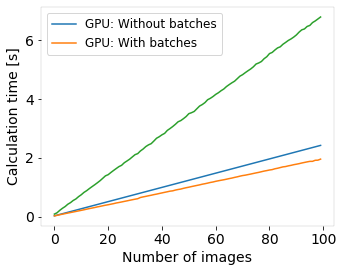

In [22]:
batch_sizes = np.linspace(1,np.shape(time_cpu)[0],np.shape(time_cpu)[0])
import matplotlib.pyplot as plt

font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=18)    
plt.rcParams['axes.linewidth'] = 0.1 #set the value globally


fig, ax = plt.subplots(figsize=[5,4])

plt.plot(time_gpu[0] * batch_sizes)
plt.plot(time_gpu)
plt.plot(time_cpu)
#plt.plot((time_gpu[0] * batch_sizes - time_gpu)/(batch_sizes-1))
plt.xlabel('Number of images')
plt.ylabel('Calculation time [s]')
plt.legend(['GPU: Without batches', 'GPU: With batches'])
fig.tight_layout()
#plt.savefig('/tf/results/results_new/' + network + 'calculation_time_batches' + '.png')

In [17]:
print(np.nanmean((time_gpu[0] * batch_sizes - time_gpu)/(batch_sizes-1))) # image transfer time
print(np.mean((time_gpu[0]*batch_sizes)/(time_gpu))) # how much longer is individual analysis

0.00508682134032856
1.247633523077999


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.



0.06798221156527529 -0.0017370547032498074
Linear fit: 	 y = 0.06798221156527529 * x + 	-0.0017370547032498074 
14.735281945651328
Linear fit: 	 y = 0.01958620383461477 * x + 	-0.002876011343729057 
51.20318464016711
Linear fit: 	 y = 0.08331579185271186 * x + 	-0.003785863865843453 
12.047966436427394


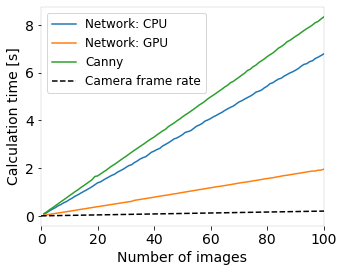

In [24]:
fig, ax = plt.subplots(figsize=[5,4])
batch_sizes = np.linspace(1,np.shape(time_cpu)[0],np.shape(time_cpu)[0])
plt.plot(batch_sizes,time_cpu)
plt.plot(batch_sizes,time_gpu)
plt.plot(batch_sizes,time_canny)
#plt.plot(batch_sizes,time_canny_2)
plt.plot([0,500],[0,1],'k--')
plt.xlim(0,np.max(batch_sizes))

plt.xlabel('Number of images')
plt.ylabel('Calculation time [s]')

plt.legend(['Network: CPU', 'Network: GPU', 'Canny','Camera frame rate'],loc=2)

fig.tight_layout()

plt.savefig('/tf/results/results_new/' + network + 'calculation_time_2' + '.png')

from statistics import mean
def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b
print()
m, b = best_fit_slope_and_intercept(batch_sizes,time_cpu)
print(m,b)
print("Linear fit: \t y = {} * x + \t{} ".format(m, b))
x = (1.0 - b) / m
print(x)

m, b = best_fit_slope_and_intercept(batch_sizes,time_gpu)
print("Linear fit: \t y = {} * x + \t{} ".format(m, b))
x = (1.0 - b) / m
print(x)

m, b = best_fit_slope_and_intercept(batch_sizes,time_canny)
print("Linear fit: \t y = {} * x + \t{} ".format(m, b))
x = (1.0 - b) / m
print(x)